## Demonstration on how the Gauss filtering works and how its parameters can be learned.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import torch
from torch import nn
from fastcore.foundation import L
from fastai.data.transforms import TfmdLists, DataLoaders, RandomSplitter, ToTensor
from fastai.losses import MSELossFlat
from fastai.learner import Learner
import fastai.callback.schedule   # Needed for fit_one_cycle

import custom_layers

In [2]:
def generate_data_for_one_feature_gauss_test(N:int, sample_len:int, noise:bool=True):
    """
    Generate a bunch of sinus signals with various frequencies and a bit of noise.

    Returns an array of size N x sample_len
    """
    rnd_offsets = np.random.rand(N) * np.pi
    rnd_frequencies = np.random.randint(1, 3, N)
    signal = np.zeros((N, sample_len), np.float32)
    for k in range(N):
        signal[k, :] = np.linspace(0,  rnd_frequencies[k] * 2 * np.pi, sample_len) - rnd_offsets[k]
        signal[k, :] = np.sin(signal[k, :])
    if noise:
        signal *= np.random.rand(N, sample_len)
    return signal.astype(np.float32)


def gen_gauss(x_arr, sigma, miu):
    """
    Generates a Gaussian kernel with support x_arr and (miu, sigma) stats.
    """
    x_arr_shift = x_arr - miu
    gauss_kern = np.exp(-np.square(x_arr_shift) / (2*sigma*sigma))
    gauss_kern = gauss_kern * 1 / (sigma * np.sqrt(2*np.pi))

    return gauss_kern

Let's init some data. We set a target transformation and apply it to a bunch of random signals.

Original data is the training data and the transformed data is the target (GT)

In [3]:
np.random.seed(343)
sample_len = 100
target_sigma = 3
target_mu = -11.5

signal = generate_data_for_one_feature_gauss_test(1, sample_len, True)  # A demo signal
signal = signal[0]

nk = sample_len - (1 - sample_len % 2)
kernel_support = np.arange(-nk/2, nk/2, 1)
kernel = gen_gauss(kernel_support, target_sigma, target_mu)  # A Gauss kernel
kernel_zero_shift = gen_gauss(kernel_support, target_sigma, 0)  # A Gauss kernel with 0 shift
filtered_sample = np.convolve(signal, kernel, mode='same')
noshift_filter_sample = np.convolve(signal, kernel_zero_shift, mode='same')


In [ ]:
fig, ax = plt.subplots(3,1, figsize=(8,6))
ax[0].plot(signal, label="Original signal")
ax[0].set_ylim([-1, 1])
ax[0].plot(noshift_filter_sample, label="Smoothed signal")
ax[0].legend()
ax[0].set_title("Some sinusoid signal with noise")
ax[1].plot(kernel_support, kernel)
ax[1].set_title("The Gauss kernel, with non zero mean")
ax[2].plot(filtered_sample, label="Transformed signal")
ax[2].plot(noshift_filter_sample, label="Smoothed signal")
ax[2].set_ylim([-1, 1])
ax[2].legend()
ax[2].set_title("Filtered signal. Note the shift!")
fig.tight_layout()
fig.savefig("fig1_filtering.png")

Can a network learn this smoothing and shifting, just by looking at a bunch of samples?

Can our layer learn such a thing?

In [5]:
def display_a_sample(tls_train, sample_id, model, title):
    """
    Helper func to display a sample of data
    """
    sample = tls_train[sample_id][0]
    sample_t = torch.tensor(sample, device=torch.device('cuda')).unsqueeze(0)
    sample_gt = tls_train[sample_id][1]
    transformed_signal = model(sample_t).detach().squeeze(0).cpu().numpy()
    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(sample, label="Original signal")
    ax[0].set_title("Data sample")
    ax[1].plot(transformed_signal, label="Network output")
    ax[1].plot(sample_gt, label="GT")
    ax[1].legend()
    ax[1].set_title("Transformed data")
    fig.suptitle(title)
    fig.tight_layout()
    return fig

In [4]:
N = 500
sample_id = 34  # We will watch this sample
signals = generate_data_for_one_feature_gauss_test(N, sample_len, True)  # A bunch of signals
gt_signals = []
for k in range(N):
    gt_sample = np.convolve(signals[k, :], kernel, mode='same')
    gt_signals.append(gt_sample)
gt_signals = np.array(gt_signals).astype(np.float32)
train_samples = zip(signals, gt_signals)
train_samples = L(train_samples)

splits = RandomSplitter(0.1)(train_samples)
tls_train = TfmdLists(train_samples[splits[0]], [ToTensor()])
tls_test = TfmdLists(train_samples[splits[1]], [ToTensor()])
dloaders = DataLoaders.from_dsets(tls_train, tls_test, bs=1, num_workers=4, device=torch.device('cuda'))
model = custom_layers.GaussConvLayer_nobackwards().to(torch.device('cuda'))
learner = Learner(dloaders, model, loss_func=MSELossFlat(reduction="mean"), model_dir="../dump")
fig = display_a_sample(tls_train, sample_id, model,"Model after the initialization")
fig.savefig("fig2_network_output.png")

NameError: name 'display_a_sample' is not defined

In [ ]:
learner.fit_one_cycle(6, 1e-2)
display_a_sample(tls_train, sample_id, model,"Model after 6 epochs");

Let's generate a nice graph showing how the parameters evolve during learning. We set a small LR so we "see" something.

epoch,train_loss,valid_loss,time
0,0.138397,0.140315,00:03


epoch,train_loss,valid_loss,time
0,0.115908,0.129088,00:03


epoch,train_loss,valid_loss,time
0,0.110171,0.118525,00:03


epoch,train_loss,valid_loss,time
0,0.099427,0.108426,00:03


epoch,train_loss,valid_loss,time
0,0.093569,0.098910,00:03


epoch,train_loss,valid_loss,time
0,0.081050,0.089555,00:03


epoch,train_loss,valid_loss,time
0,0.072834,0.080784,00:03


epoch,train_loss,valid_loss,time
0,0.074176,0.072354,00:03


epoch,train_loss,valid_loss,time
0,0.055537,0.064894,00:03


epoch,train_loss,valid_loss,time
0,0.055373,0.057852,00:03


epoch,train_loss,valid_loss,time
0,0.048135,0.051451,00:03


epoch,train_loss,valid_loss,time
0,0.042002,0.045641,00:04


epoch,train_loss,valid_loss,time
0,0.039499,0.040618,00:03


epoch,train_loss,valid_loss,time
0,0.034086,0.036096,00:03


epoch,train_loss,valid_loss,time
0,0.031478,0.032212,00:03


epoch,train_loss,valid_loss,time
0,0.025917,0.028786,00:03


epoch,train_loss,valid_loss,time
0,0.023868,0.025370,00:03


epoch,train_loss,valid_loss,time
0,0.020228,0.022116,00:03


epoch,train_loss,valid_loss,time
0,0.017917,0.019012,00:03


epoch,train_loss,valid_loss,time
0,0.013806,0.016063,00:03


epoch,train_loss,valid_loss,time
0,0.012660,0.013272,00:03


epoch,train_loss,valid_loss,time
0,0.010494,0.010704,00:03


epoch,train_loss,valid_loss,time
0,0.007630,0.008383,00:03


epoch,train_loss,valid_loss,time
0,0.006237,0.006303,00:03


epoch,train_loss,valid_loss,time
0,0.004513,0.004500,00:03


epoch,train_loss,valid_loss,time
0,0.002724,0.003008,00:03


epoch,train_loss,valid_loss,time
0,0.001650,0.001800,00:03


epoch,train_loss,valid_loss,time
0,0.000849,0.000922,00:03


epoch,train_loss,valid_loss,time
0,0.000335,0.000350,00:03


epoch,train_loss,valid_loss,time
0,0.000067,0.000069,00:03


epoch,train_loss,valid_loss,time
0,0.000002,0.000001,00:03


epoch,train_loss,valid_loss,time
0,0.000000,0.000000,00:03


epoch,train_loss,valid_loss,time
0,0.000000,0.000000,00:04


epoch,train_loss,valid_loss,time
0,0.000000,0.000000,00:03


epoch,train_loss,valid_loss,time
0,0.000000,0.000000,00:03


epoch,train_loss,valid_loss,time
0,0.000000,0.000000,00:03


epoch,train_loss,valid_loss,time
0,0.000000,0.000000,00:03


epoch,train_loss,valid_loss,time
0,0.000000,0.000000,00:03


epoch,train_loss,valid_loss,time
0,0.000000,0.000000,00:03


epoch,train_loss,valid_loss,time
0,0.000000,0.000000,00:03


epoch,train_loss,valid_loss,time
0,0.000000,0.000000,00:03


epoch,train_loss,valid_loss,time
0,0.000000,0.000000,00:03


epoch,train_loss,valid_loss,time
0,0.000000,0.000000,00:03


epoch,train_loss,valid_loss,time
0,0.000000,0.000000,00:03


epoch,train_loss,valid_loss,time
0,0.000000,0.000000,00:03


epoch,train_loss,valid_loss,time
0,0.000000,0.000000,00:03


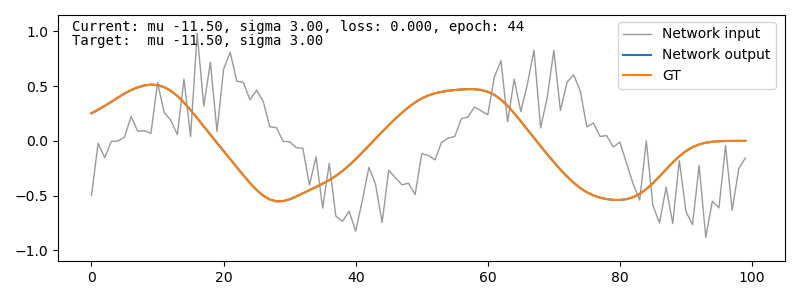

In [6]:
def plot_a_frame(ax, tls_train, sample_id, learner, epoch_no):
    if hasattr(learner, "smooth_loss"):
        crt_loss = learner.smooth_loss.item()
    else:
         crt_loss = 1   
    crt_mu = learner.model.mu.detach().item()
    crt_sigma = learner.model.sigma.detach().item()
    sample = tls_train[sample_id][0]
    sample_t = torch.tensor(sample, device=torch.device('cuda')).unsqueeze(0)
    sample_gt = tls_train[sample_id][1]
    transformed_signal = learner.model(sample_t).detach().squeeze(0).cpu().numpy()
    crt_string =    f"Current: mu {crt_mu:>6.2f}, sigma {crt_sigma:<4.2f}, loss: {crt_loss:5.3f}, epoch: {epoch_no:2d}"
    target_string = f"Target:  mu {target_mu:>6.2f}, sigma {target_sigma:<4.2f}"
    fontdict = {"family": "monospace"}
    ax.set_xlim(-5, 105)
    ax.set_ylim(-1.1, 1.15)
    ax.plot(sample, label="Network input",linewidth=1, alpha = 0.4, color="k")
    ax.plot(transformed_signal, label="Network output")
    ax.plot(sample_gt, label="GT")
    ax.text(-3, 1, crt_string, fontdict)
    ax.text(-3, 0.88, target_string, fontdict)
    ax.legend(loc=(0.77, 0.7))    

fig, ax = plt.subplots(1,1, figsize=(8,3))
# plot_a_frame(ax, tls_train, sample_id, learner, 1)

def animate_func(i):
    ax.clear()
    learner.fit_one_cycle(1, 2e-3)
    plot_a_frame(ax, tls_train, sample_id, learner, i)
    fig.tight_layout()
    
learner.model.init_params()    
the_animation = animation.FuncAnimation(fig, animate_func, list(range(45)), )  # 60
the_animation.save("fig3_learning.gif", dpi=120, writer=animation.PillowWriter(fps=10))